In [1]:
import numpy as np
import os

# Colab에서 TensorFlow를 사용할 때 GPU 환경을 설정하는 코드
# GPU 디바이스를 선택하고 TensorFlow가 GPU 메모리를 동적으로 할당하도록 설정
# colab에서는 이 기능 사용 안 해도 됨
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
actions = [
    'up',
    'down',
    'left',
    'right',
    'ready'
]
# /content/drive/MyDrive/[2024]호남대학교/dataset
data = np.concatenate([
    np.load('/content/drive/MyDrive/[2024]호남대학교/dataset/seq_up_1704722198.npy'),
    np.load('/content/drive/MyDrive/[2024]호남대학교/dataset/seq_down_1704722198.npy'),
    np.load('/content/drive/MyDrive/[2024]호남대학교/dataset/seq_left_1704722198.npy'),
    np.load('/content/drive/MyDrive/[2024]호남대학교/dataset/seq_right_1704722198.npy'),
    np.load('/content/drive/MyDrive/[2024]호남대학교/dataset/seq_ready_1704722198.npy')
], axis=0)

data.shape

(2153, 30, 100)

### 문제 답지 분리
 - x_data: 문제
 - labels: 답지

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2153, 30, 99)
(2153,)


In [5]:
# 2번째 문제 데이터 확인
x_data[1]

array([[ 2.95293570e-01,  1.02539587e+00, -4.40795667e-08, ...,
         1.28693237e+01,  1.71977371e+02,  1.14030056e+01],
       [ 2.97195107e-01,  1.02763593e+00,  1.99277772e-09, ...,
         1.31561441e+01,  1.71786636e+02,  1.09612999e+01],
       [ 2.96933711e-01,  1.02742827e+00,  3.42352529e-08, ...,
         1.36586609e+01,  1.70311325e+02,  1.01075621e+01],
       ...,
       [ 3.32372755e-01,  8.80335689e-01,  8.12889098e-08, ...,
         2.26551361e+01,  1.57995331e+02,  1.39485703e+01],
       [ 3.38055104e-01,  8.72951269e-01,  8.88454323e-08, ...,
         2.23698425e+01,  1.59419922e+02,  1.47871456e+01],
       [ 3.39237481e-01,  8.82983327e-01,  4.93369505e-08, ...,
         2.06860428e+01,  1.59912933e+02,  1.30746260e+01]])

In [6]:
# 2번째 답지 데이터 확인
labels[1000]

2.0

### 원 핫 인코딩
 - 0 [1,0,0,0,0]
 - 1 [0,1,0,0,0]
 - 2 [0,0,1,0,0]
 - 3 [0,0,0,1,0]
 - 4 [0,0,0,0,1]

In [7]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2153, 5)

### 데이터 분리
 -  train, test data 분리

In [8]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1937, 30, 99) (1937, 5)
(216, 30, 99) (216, 5)


In [9]:
x_train.shape[1:3]

(30, 99)

### 딥러닝 모델 만들기
 - 시퀀설 데이터 즉 시계열 예측 모델은
  - LSTM,GRU 사용

In [10]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import LSTM,Dense


model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
   #LSTM(64, activation='relu', input_shape=(30,99)),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
    # 이진 sigmoid, 다중 softmax
])
# 2진분류 loss='binary_crossentropy'
# 다중분류 원핫인코딩 on  loss='categorical_crossentropy'
# 다중분류 원핫인코딩 off loss='sparse_categorical_crossentropy'
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 44229 (172.77 KB)
Trainable params: 44229 (172.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# lr 조절하는 부분 ReduceLROnPlateau
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('/content/drive/MyDrive/[2024]호남대학교/models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
61/61 [==============================] - ETA: 0s - loss: 32.4671 - acc: 0.3867
Epoch 1: val_acc improved from -inf to 0.85648, saving model to /content/drive/MyDrive/[2024]호남대학교/models/model.h5
61/61 [==============================] - 8s 50ms/step - loss: 32.4671 - acc: 0.3867 - val_loss: 1.3132 - val_acc: 0.8565 - lr: 0.0010
Epoch 2/200
 3/61 [>.............................] - ETA: 1s - loss: 1.0080 - acc: 0.8854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/61 [============================>.] - ETA: 0s - loss: 0.8868 - acc: 0.9266
Epoch 2: val_acc improved from 0.85648 to 0.97222, saving model to /content/drive/MyDrive/[2024]호남대학교/models/model.h5
61/61 [==============================] - 2s 38ms/step - loss: 0.8899 - acc: 0.9267 - val_loss: 0.3447 - val_acc: 0.9722 - lr: 0.0010
Epoch 3/200
60/61 [============================>.] - ETA: 0s - loss: 0.9663 - acc: 0.9375
Epoch 3: val_acc did not improve from 0.97222
61/61 [==============================] - 3s 44ms/step - loss: 0.9579 - acc: 0.9380 - val_loss: 0.4289 - val_acc: 0.9537 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - ETA: 0s - loss: 0.4885 - acc: 0.9602
Epoch 4: val_acc did not improve from 0.97222
61/61 [==============================] - 2s 33ms/step - loss: 0.4885 - acc: 0.9602 - val_loss: 0.3425 - val_acc: 0.9676 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - ETA: 0s - loss: 1.1870 - acc: 0.9391
Epoch 5: val_acc did not improve fro

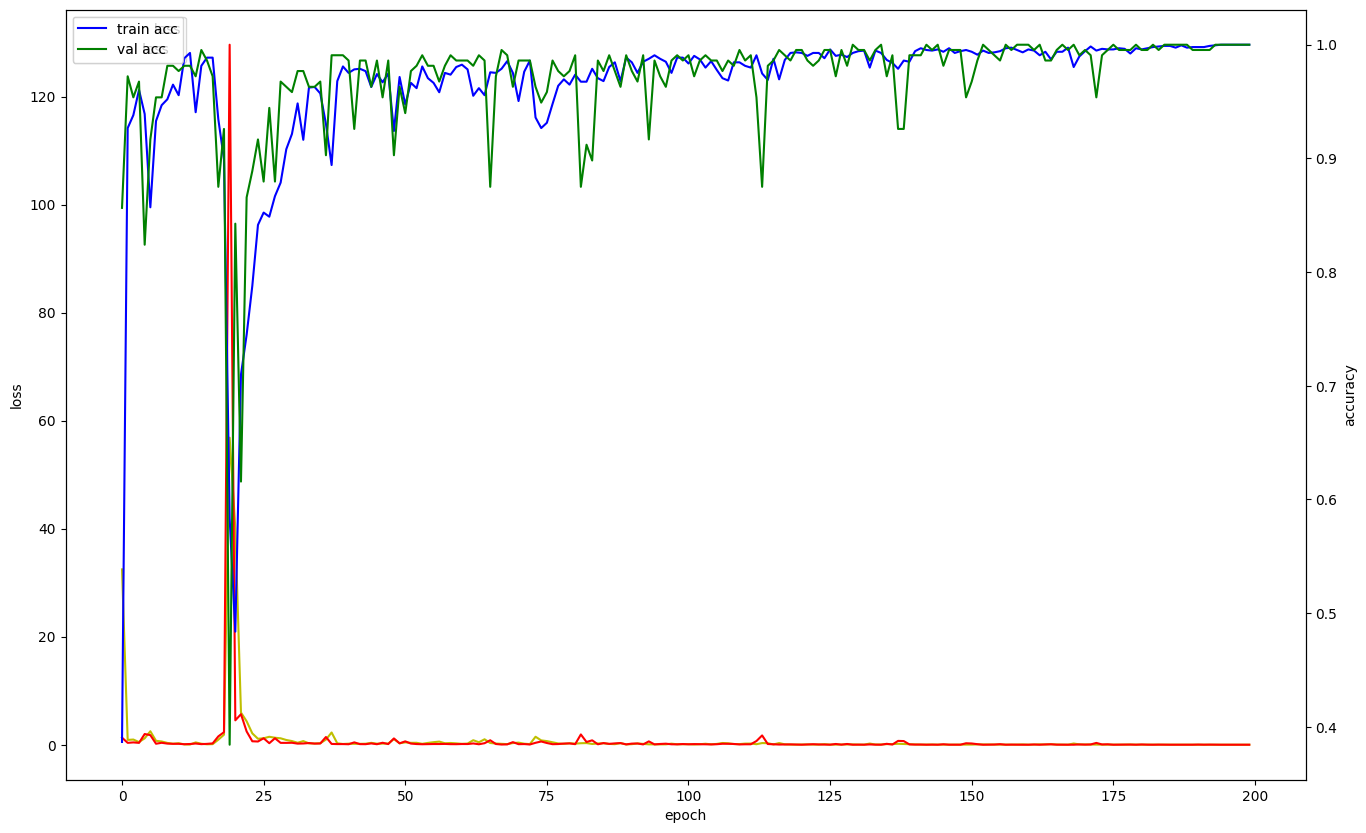

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
# from tensorflow.keras.models import load_model
from keras.models import load_model

model = load_model('/content/drive/MyDrive/[2024]호남대학교/models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

7/7 [==============================] - 0s 6ms/step


array([[[170,   0],
        [  0,  46]],

       [[164,   0],
        [  0,  52]],

       [[190,   0],
        [  0,  26]],

       [[172,   0],
        [  0,  44]],

       [[168,   0],
        [  0,  48]]])